# Titanic Survival (Ensemble approach)

In this Kaggle project I will attempt to correctly predict whom survived the Titanic shipwreck. I will attempt to use several Machine Learning techniques (ensemble of models) to see which model has the best accuracy. This ensemble approach is inspired by Kaggle contributor and youtuber Ken Jee. Instead of extreme gradient boosting I included Ada Boost and Gradient Boosting classifiers. I attempted to use small tweaks to his models in order to improve the discriminatory power. Instead of simple mean or median imputation I used multivariate imputations by chained equations in order to replace the missing values afferent to the Age variable with estimates using Python's experimental IterativeImputer along with the DecisionTreeRegressor() estimator in order to avoid imputting negative Age values. Although there was no substantial difference overall, the multiple imputation framework slightly improved the performance afferent to some of the models when compared to simple imputation. At the end,I tried developing voting classifiers using different combinations of models and weights in order to find the model with the best performance.

## Overview¶
1.  Preliminary visualisations
2.  Data Cleaning
3.  Data Exploration
4.  Feature Engineering
5.  Data Preprocessing for Model
6.  Basic Model Building
7.  Model Tuning
8.  Ensemble Modle Building
9.  Results

First, I will import all the necessary packages and set my working directory.



In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('D:\Study\Datasets\Titanic dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\Study\Datasets\Titanic dataset\base_submission.csv
D:\Study\Datasets\Titanic dataset\gender_submission.csv
D:\Study\Datasets\Titanic dataset\submission_rf.csv
D:\Study\Datasets\Titanic dataset\test.csv
D:\Study\Datasets\Titanic dataset\Titanic Survival (Ensemble approach) .ipynb
D:\Study\Datasets\Titanic dataset\titanic.zip
D:\Study\Datasets\Titanic dataset\train.csv
D:\Study\Datasets\Titanic dataset\xgboost-1.2.0.tar.gz


Next, I will read the data downloaded from Kaggle and create the training and test datasets.

In [2]:
training = pd.read_csv(r'D:\Study\Datasets\Titanic dataset\train.csv')
test = pd.read_csv(r'D:\Study\Datasets\Titanic dataset\test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

print(all_data.head(15))

C:\Users\i5\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


     Age Cabin Embarked     Fare  \
0   22.0   NaN        S   7.2500   
1   38.0   C85        C  71.2833   
2   26.0   NaN        S   7.9250   
3   35.0  C123        S  53.1000   
4   35.0   NaN        S   8.0500   
5    NaN   NaN        Q   8.4583   
6   54.0   E46        S  51.8625   
7    2.0   NaN        S  21.0750   
8   27.0   NaN        S  11.1333   
9   14.0   NaN        C  30.0708   
10   4.0    G6        S  16.7000   
11  58.0  C103        S  26.5500   
12  20.0   NaN        S   8.0500   
13  39.0   NaN        S  31.2750   
14  14.0   NaN        S   7.8542   

                                                 Name  Parch  PassengerId  \
0                             Braund, Mr. Owen Harris      0            1   
1   Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                              Heikkinen, Miss. Laina      0            3   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                            Allen, Mr

## Exploratory Data Analysis (EDA)
### 1) For numeric data
Made histograms to understand distributions
Corrplot
Pivot table comparing survival rate across numeric variables
### 2) For Categorical Data
Made bar charts to understand balance of classes
Made pivot tables to understand relationship with survival

In [3]:
#quick look at our data types & null counts 
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
train_test     891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 73.2+ KB


We can see above that the Age variable has 177 missing values (19.9%), the Cabin variable has 687 missing values (77.1%) and the Embarked variable has 2 missing values (0.22%). Due to the very large number of missing values, the Cabin variable cannot be used and will be dropped in the subseuent sections. Unlike the Cabin variable, because the Embarked column only has 2 missing values, the missing observations can be dropped without a large impact on the estimates of the models to be fitted. Only the age variable is subject to imputation (in order to preserve information).

In [4]:
# to better understand the numeric data, we want to use the .describe() method. This gives us an understanding of the central tendencies of the data 
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [5]:
#quick way to separate numeric columns
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [6]:
# look at numeric and categorical values separately 
df_num = training[['Age','SibSp','Parch','Fare']]
df_num_test = test[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

C:\Users\i5\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\i5\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


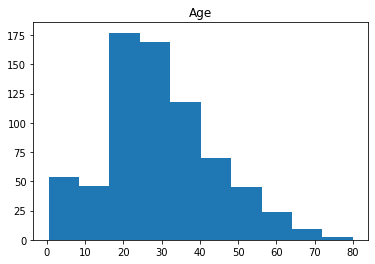

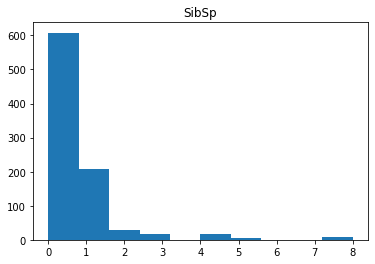

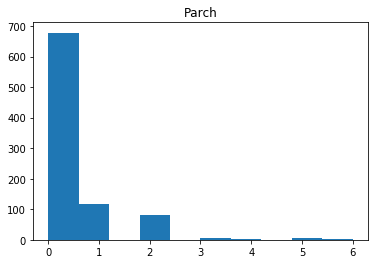

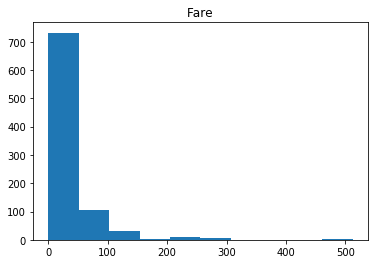

In [7]:
#distributions for all numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

Perhaps we should take the non-normal distributions and consider normalizing them?

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


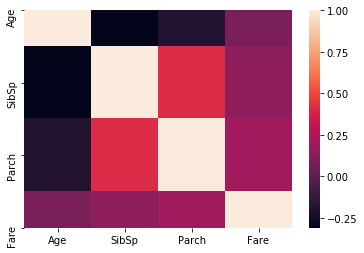

In [8]:
print(df_num.corr())
sns.heatmap(df_num.corr())

In [9]:
# compare survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(training, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


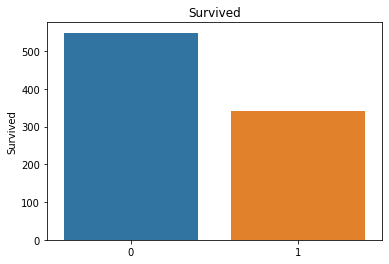

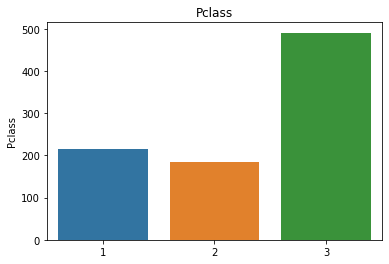

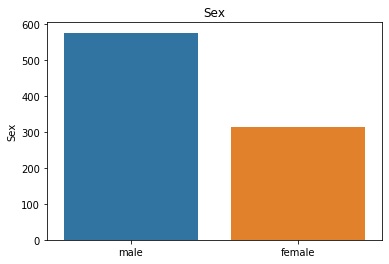

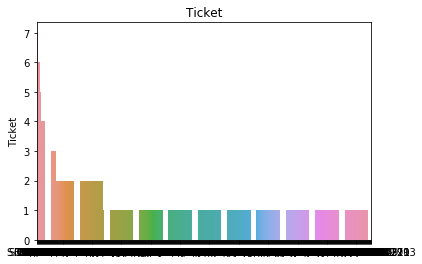

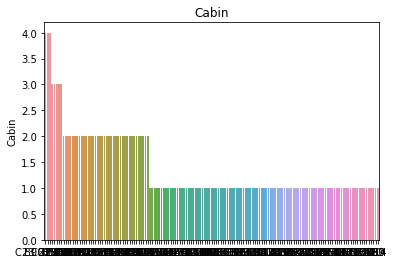

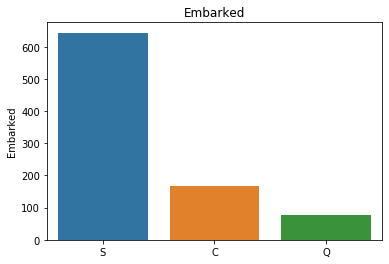

In [10]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()

For the Cabin and Ticket graphs, the values on the x axis are very crowded and, therefore difficult to interpret. Some feature engineering might be necessary.

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119



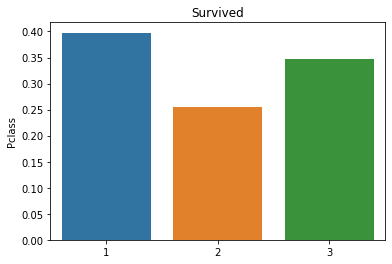

Sex       female  male
Survived              
0             81   468
1            233   109



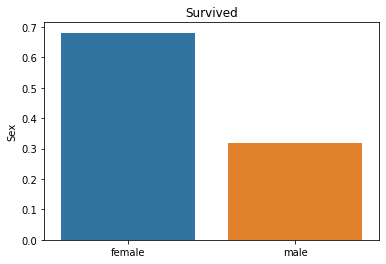

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217



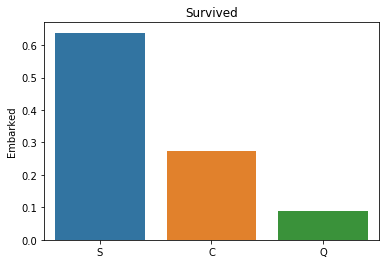

In [11]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
sns.barplot(training.loc[training["Survived"]==1,"Pclass"].value_counts(normalize=True).index,training.loc[training["Survived"]==1,'Pclass'].value_counts(normalize=True)).set_title("Survived")
plt.show()
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
sns.barplot(training.loc[training["Survived"]==1,"Sex"].value_counts(normalize=True).index,training.loc[training["Survived"]==1,"Sex"].value_counts(normalize=True)).set_title("Survived")
plt.show()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))
print()
sns.barplot(training.loc[training["Survived"]==1,"Embarked"].value_counts(normalize=True).index,training.loc[training["Survived"]==1,"Embarked"].value_counts(normalize=True)).set_title("Survived")
plt.show()

Feature Engineering
1.  Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)¶
2.  Tickets - Do different ticket types impact survival rates?
3.  Does a person's title relate to survival rates?

In [12]:
df_cat.Cabin
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# after looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this 
# letters 
# multiple letters 
training['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [13]:
pd.pivot_table(training, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [14]:
#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category

training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])

In [15]:
#comparing surivial rate by cabin
print(training.cabin_adv.value_counts())
pd.pivot_table(training,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [16]:
#understand ticket values better 
#numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [17]:
training['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [18]:
#lets us view all rows in dataframe through scrolling. This is for convenience 
pd.set_option("max_rows", None)
training['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
c              5
fcc            5
pp             3
wep            3
sopp           3
ppp            2
scah           2
swpp           2
sotono2        2
sc             1
as             1
sop            1
scahbasle      1
sp             1
scow           1
casoton        1
fa             1
fc             1
sca4           1
Name: ticket_letters, dtype: int64

In [19]:
#difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(training,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [20]:
#feature engineering on person's title 
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

In [21]:
training['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Don               1
Jonkheer          1
Ms                1
Sir               1
the Countess      1
Lady              1
Mme               1
Capt              1
Name: name_title, dtype: int64

## Data Preprocessing for Model¶
1.  Dropped null values from Embarked (only 2)
2.  Included only relevant variables (only  excluded name and passanger ID)
Variables: 'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title'

3. Applied categorical transforms on all data. 
4. Used multiple imputation with chained equations in Python to replace missing values.
5. Used log-transform in order to normalized fare.
6. Scaled data 0-1 with standard scaler.



In [22]:
#create all categorical variables that we did above for both training and test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

df_cat_all = all_data[['Survived','Pclass','Sex','Ticket','Cabin','Embarked','cabin_multiple','cabin_adv','numeric_ticket','ticket_letters','name_title','train_test']]


#impute values for continuous data 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor 
from pandas import DataFrame

#When I used the default BayesianRidge() estimator. The problem was that it also produced negative values of age (impossible). 
#In order to ensure positive age values while preserving the distribution of the values prior to the imputation, 
#I used DecisionTreeRegressor().


imp = IterativeImputer(estimator=DecisionTreeRegressor(),max_iter=10, random_state=0,verbose=0, initial_strategy='mean')
training_num_clean=DataFrame(imp.fit_transform(df_num),columns=['Age','SibSp','Parch','Fare'])
print(df_num.head(10))
print()
print(training_num_clean.head(10))
print()
test_num_clean = DataFrame(imp.transform(df_num_test),columns=['Age','SibSp','Parch','Fare'])
print(test_num_clean.head(10))
all_data_num_clean = pd.concat([training_num_clean,test_num_clean])
print()
print(all_data_num_clean.head(10))

all_data_clean =pd.concat([all_data_num_clean,df_cat_all], axis=1, ignore_index=False)

print(all_data_clean.columns)

    Age  SibSp  Parch     Fare
0  22.0      1      0   7.2500
1  38.0      1      0  71.2833
2  26.0      0      0   7.9250
3  35.0      1      0  53.1000
4  35.0      0      0   8.0500
5   NaN      0      0   8.4583
6  54.0      0      0  51.8625
7   2.0      3      1  21.0750
8  27.0      0      2  11.1333
9  14.0      1      0  30.0708

    Age  SibSp  Parch     Fare
0  22.0    1.0    0.0   7.2500
1  38.0    1.0    0.0  71.2833
2  26.0    0.0    0.0   7.9250
3  35.0    1.0    0.0  53.1000
4  35.0    0.0    0.0   8.0500
5  21.0    0.0    0.0   8.4583
6  54.0    0.0    0.0  51.8625
7   2.0    3.0    1.0  21.0750
8  27.0    0.0    2.0  11.1333
9  14.0    1.0    0.0  30.0708

    Age  SibSp  Parch     Fare
0  34.5    0.0    0.0   7.8292
1  47.0    1.0    0.0   7.0000
2  62.0    0.0    0.0   9.6875
3  27.0    0.0    0.0   8.6625
4  22.0    1.0    1.0  12.2875
5  14.0    0.0    0.0   9.2250
6  30.0    0.0    0.0   7.6292
7  26.0    1.0    1.0  29.0000
8  18.0    0.0    0.0   7.2292
9  21.

(889,)

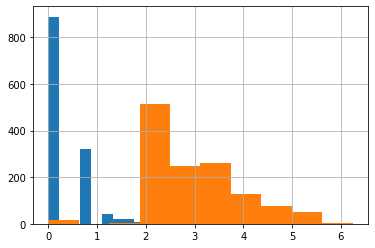

In [25]:
#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
all_data_clean.dropna(subset=['Embarked'],inplace = True)

#tried log norm of sibsp (not used)
all_data_clean['norm_sibsp'] = np.log(all_data_clean.SibSp+1)
all_data_clean['norm_sibsp'].hist()

# log norm of fare (used)
all_data_clean['norm_fare'] = np.log(all_data_clean.Fare+1)
all_data_clean['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data_clean.Pclass = all_data_clean.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data_clean[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data_clean[all_data_clean.train_test==1].Survived
y_train.shape

C:\Users\i5\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\i5\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\i5\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

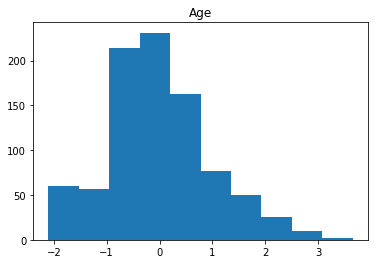

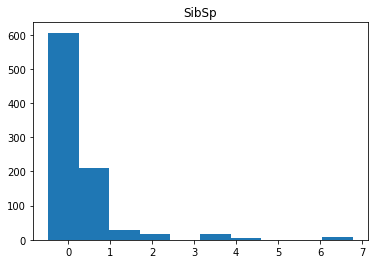

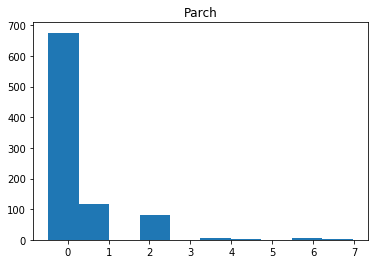

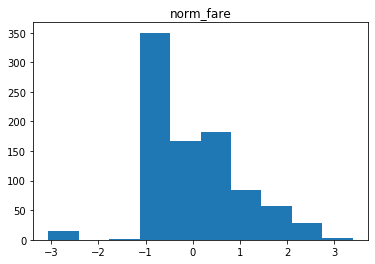

In [27]:
# Scale data 
from sklearn.preprocessing import StandardScaler

all_dummies_v2 = all_dummies.copy()
all_dummies_train_scaled=all_dummies_v2[all_dummies_v2.train_test == 1]
all_dummies_test_scaled=all_dummies_v2[all_dummies_v2.train_test == 0]
scale = StandardScaler().fit(all_dummies_train_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_train_scaled[['Age','SibSp','Parch','norm_fare']]= scale.transform(all_dummies_train_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_test_scaled[['Age','SibSp','Parch','norm_fare']]= scale.transform(all_dummies_test_scaled[['Age','SibSp','Parch','norm_fare']])


X_train_scaled = all_dummies_train_scaled.drop(['train_test'], axis =1)
X_test_scaled = all_dummies_test_scaled.drop(['train_test'], axis =1)

y_train = all_data_clean[all_data_clean.train_test==1].Survived

for i in X_train_scaled[['Age','SibSp','Parch','norm_fare']].columns:
    plt.hist(X_train_scaled[i])
    plt.title(i)
    plt.show()

## Model Building (Baseline Validation Performance)¶
Before going further, I like to see how various different models perform with default parameters. I tried the following models using 5 fold cross validation to get a baseline. With a validation set baseline, we can see how much tuning improves each of the models. Just because a model has a high basline on this validation set doesn't mean that it will actually do better on the eventual test set.
 
* Naive Bayes (72.21%)
* Logistic regression (82.34%)
* Logistic regression using scaled data (82.46%)
* Decision tree (78.06%)
* Decision tree using scaled data (78.06%)
* K nearest neighbor (80.99%)
* K nearest neighbor using scaled data (81.11%)
* Random forest (81.33%)
* Random forest using scaled data (81.33%)
* Support vector classifier using scaled data (82.91%)
* Ada boost classifier using scaled data (81.33%)
* Gradient boosting classifier using scaled data (83.13%)
* Soft voting classifier - all models (82.34%)

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
0.7221735542436362


In [30]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.82022472 0.81460674 0.80337079 0.82022472 0.85875706]
0.8234368056878054


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82022472 0.81460674 0.80898876 0.82022472 0.85875706]
0.8245604011934233


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

In [32]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79775281 0.78089888 0.8258427  0.73033708 0.76836158]
0.7806386085190123


In [33]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.78089888 0.82022472 0.7247191  0.76836158]
0.7806386085190122


In [34]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.80898876 0.78089888 0.80898876 0.84180791]
0.8099346156287691


In [36]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80337079 0.79213483 0.8258427  0.79213483 0.83615819]
0.8099282676315622


In [37]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.80337079 0.85955056 0.76966292 0.82485876]
0.8132863581540024


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

In [38]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.81460674 0.80337079 0.84831461 0.76966292 0.82485876]
0.8121627626483845


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

In [39]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The defa

[0.84831461 0.8258427  0.82022472 0.79775281 0.85875706]
0.8301783787215132


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [41]:
abc = AdaBoostClassifier()
# n_estimators = 50 (default value)
# base_estimator = DecisionTreeClassifier (default value)
cv = cross_val_score(abc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79775281 0.80337079 0.80337079 0.80898876 0.85310734]
0.8133180981400369


In [42]:
gbc = GradientBoostingClassifier()
# n_estimators = 100 (default)
# loss function = deviance(default) used in Logistic Regression
cv = cross_val_score(gbc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.80898876 0.87078652 0.79775281 0.8700565 ]
0.831314670221545


In [43]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('abc',abc),('gbc',gbc)], voting = 'soft') 

In [44]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\fores

[0.83146067 0.81460674 0.8258427  0.79775281 0.86440678]
0.8268139402018664


In [45]:
voting_clf.fit(X_train_scaled,y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Model Tuned Performance
After getting the baselines, let's see if we can improve on the indivdual model results!I mainly used grid search to tune the models. I also used Randomized Search for the Random Forest and the boosted models to simplify testing time.

| Model | Baseline | Tuned Performance |
| --- | --- | --- |
| Naive Bayes | 72.21% | NA|
| Logistic regression using scaled data | 82.46% | 82.23% |
| Decision tree using scaled data |78.06% | NA |
| K nearest neighbor using scaled data | 81.11% | 82.11% |
| Random forest using scaled data | 81.33% | 84.14% |
| Support vector classifier | 82.91% | 83.13% |
| Ada boost classifier using scaled data | 81.33% | 81.78% |
| Gradient boosting classifier using scaled data| 83.13% | 83.8%  |

In [46]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [47]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [48]:
#Attempted to use regularization, but the results were worse than initially. Henceforth, the 
#default logistic regression without tuning is to be used as a part of the ensemble models.

lr2 = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1','l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['saga']}

clf_lr = GridSearchCV(lr2, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

#Logistic Regression
#Best Score: 0.8222722159730034
#Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished


Logistic Regression
Best Score: 0.8222722159730034
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}


In [49]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

#KNN
#Best Score: 0.8211473565804275
#Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    2.0s


KNN
Best Score: 0.8211473565804275
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.4s finished


In [50]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

#SVC
#Best Score: 0.8312710911136107
#Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 245 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  7.4min finished


SVC
Best Score: 0.8312710911136107
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [51]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

#Random Forest
#Best Score: 0.8413948256467941
#Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 550}

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 10.6min finished


Random Forest
Best Score: 0.8413948256467941
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 550}


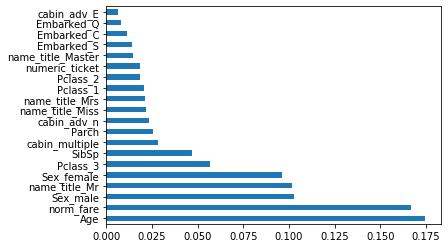

In [52]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [61]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [100, 200, 300, 400, 500, 600, 1000],
              "learning_rate": [0.001, 0.00075, 0.0005, 0.00025, 0.00001]
             }


DTC = tree.DecisionTreeClassifier(random_state = 1, max_features = "auto", class_weight = "balanced",max_depth = None)

abc = AdaBoostClassifier(base_estimator = DTC)

# run grid search
clf_abc = GridSearchCV(abc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_abc = clf_abc.fit(X_train_scaled,y_train)
clf_performance(best_clf_abc,'Ada Boost Classifier')

#Ada Boost Classifier
#Best Score: 0.8177727784026997
#Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'random', 'learning_rate': 0.0005, 'n_estimators': 100}

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  9.2min finished


Ada Boost Classifier
Best Score: 0.8143982002249719
Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'learning_rate': 0.00075, 'n_estimators': 500}


In [53]:
param_grid = {"max_depth": [5, 6, 10, 15],
              "n_estimators": [32, 100],
              "learning_rate": [0.01, 0.001],
              "max_features": [2, 4, 6, 8, 10]
             }

gbc = GradientBoostingClassifier()

# run grid search
clf_gbc = GridSearchCV(gbc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_gbc = clf_gbc.fit(X_train_scaled,y_train)
clf_performance(best_clf_gbc,'Gradient Boosting Classifier')

#Gradient Boosting Classifier
#Best Score: 0.8380202474690663
#Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 8, 'n_estimators': 100}

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 247 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.9min finished


Gradient Boosting Classifier
Best Score: 0.8380202474690663
Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 8, 'n_estimators': 100}


After hyperparameter tuning, the random forest performed the best followed by the gradient boosting classifier.

In [54]:
y_hat_rf = best_clf_rf.best_estimator_.predict(X_test_scaled).astype(int)
rf_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission_rf = pd.DataFrame(data=rf_submission)
submission_rf.to_csv('rf_submission3.csv', index=False)

Model Additional Ensemble Approaches¶
1.  Experimented with a hard voting classifier of three estimators (KNN, SVC, RF) (83.02%)

2.  Experimented with a soft voting classifier of three estimators (KNN, SVC, RF) (83.02%) 

3.  Experimented with soft voting on all 6 estimators (KNN, RF, LR, SVC, ABC, GBC) (83.69%)

4.  Experimented with soft voting on all estimators excludinc ABC (KNN, SVC, RF, LR, GBC) (83.8%)(Best Performance)

In [55]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_abc = best_clf_abc.best_estimator_
best_gbc = best_clf_gbc.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr),('abc',best_abc), ('gbc', best_gbc)], voting = 'soft') 
voting_clf_best = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr), ('gbc', best_gbc)], voting = 'soft') 

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train,y_train,cv=5).mean())

print('voting_clf_best :',cross_val_score(voting_clf_best,X_train,y_train,cv=5))
print('voting_clf_best mean :',cross_val_score(voting_clf_best,X_train,y_train,cv=5).mean())

voting_clf_hard : [0.84269663 0.82022472 0.82022472 0.79775281 0.8700565 ]
voting_clf_hard mean : 0.8301910747159271
voting_clf_soft : [0.8258427  0.8258427  0.81460674 0.80337079 0.8700565 ]
voting_clf_soft mean : 0.8301847267187202


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

voting_clf_all : [0.84269663 0.8258427  0.86516854 0.80337079 0.85310734]


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

voting_clf_all mean : 0.8369136037580145


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

voting_clf_best : [0.84831461 0.8258427  0.8258427  0.81460674 0.87570621]


C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\i5\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

voting_clf_best mean : 0.8380625912524599


In [59]:
#in a soft voting classifier you can weight some models more than others. I used a grid search to explore different weightings
#no new results here
params = {'weights' : [[1,3,1,1,2],[1,3,2,1,2],[1,3,2,1,3],[1,4,2,1,3],[1,1,1,1,1],[1,2,1,1,1],[1,2,1,1,2],[0.2,0.2,0.2,0.2,0.2]]}

vote_weight = GridSearchCV(voting_clf_best, param_grid = params, cv = 5, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train_scaled,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   45.0s finished


VC Weights
Best Score: 0.8323959505061868
Best Parameters: {'weights': [1, 4, 2, 1, 3]}


In [61]:
#Make Predictions 
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_all.fit(X_train_scaled, y_train)
voting_clf_best.fit(X_train_scaled, y_train)

best_rf.fit(X_train_scaled, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_rf = best_rf.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test_scaled).astype(int)
y_hat_vc_best = voting_clf_best.predict(X_test_scaled).astype(int)

In [67]:
#convert output to dataframe 
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': test.PassengerId, 'Survived':y_hat_vc_soft}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_all}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_best}
submission_4 = pd.DataFrame(data=final_data_4)

final_data_5 = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': test.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_rf': y_hat_rf, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all,  'Survived_vc_best' : y_hat_vc_best}
comparison = pd.DataFrame(data=final_data_comp)

In [68]:
#track differences between outputs 
comparison['difference_rf_vc_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_rf else 0, axis =1)
comparison['difference_soft_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_vc_soft else 0, axis =1)
comparison['difference_hard_all'] = comparison.apply(lambda x: 1 if x.Survived_vc_all != x.Survived_vc_hard else 0, axis =1)

In [69]:
comparison.difference_hard_all.value_counts()

0    395
1     23
Name: difference_hard_all, dtype: int64

In [71]:
#prepare submission files 
submission.to_csv('submission_vc_hard.csv',index=False)
submission_2.to_csv('submission_vc_soft.csv', index=False)
submission_3.to_csv('submission_vc_all.csv', index=False)
submission_4.to_csv('submission_vc_best.csv', index=False)
submission_5.to_csv('submission_rf.csv', index =False)

## Conclusion

The tuned random forest trained on the scaled data had the best performance; with the best score of 84.14%. The aforementioned model performed even better than the best voting classifier.